need to use colab for gpus

1. Setup and Load Data

1.1 Install Dependencies and Setup

In [1]:
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.models.segmentation
import torch
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import scipy.io
from sklearn.model_selection import train_test_split
import random
from torchviz import make_dot
import torch.optim as optim
from torchsummary import summary

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10  # there are 10 digits: 0 to 9
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# If you are on CoLab and successfully using the GPU, this print should
#   contain "cuda" in it
print(str(device))
assert('cuda' in str(device))  # comment out this assert if you are not using a GPU

torch.cuda.empty_cache()

cuda:0


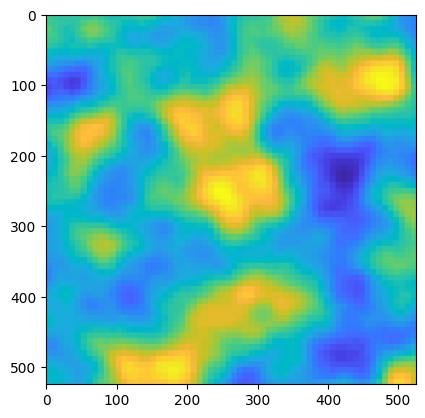

In [2]:
x = cv2.cvtColor(cv2.imread('trainingdataimages/gentrain_006.png'), cv2.COLOR_BGR2RGB)
x
plt.imshow(x)

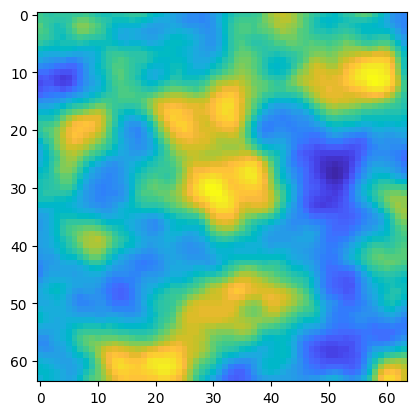

In [3]:
x = cv2.resize(x, (64,64), interpolation=cv2.INTER_LINEAR)
plt.imshow(x)

In [4]:
image = Image.open('trainingdataimages/gentrain_001.png')
data = np.asarray(image)
data

array([[[143, 202,  77],
        [143, 202,  77],
        [143, 202,  77],
        ...,
        [ 43, 195, 167],
        [ 43, 195, 167],
        [ 43, 195, 167]],

       [[143, 202,  77],
        [143, 202,  77],
        [143, 202,  77],
        ...,
        [ 43, 195, 167],
        [ 43, 195, 167],
        [ 43, 195, 167]],

       [[143, 202,  77],
        [143, 202,  77],
        [143, 202,  77],
        ...,
        [ 43, 195, 167],
        [ 43, 195, 167],
        [ 43, 195, 167]],

       ...,

       [[ 49, 197, 159],
        [ 49, 197, 159],
        [ 49, 197, 159],
        ...,
        [ 31, 164, 226],
        [ 31, 164, 226],
        [ 31, 164, 226]],

       [[ 49, 197, 159],
        [ 49, 197, 159],
        [ 49, 197, 159],
        ...,
        [ 31, 164, 226],
        [ 31, 164, 226],
        [ 31, 164, 226]],

       [[ 49, 197, 159],
        [ 49, 197, 159],
        [ 49, 197, 159],
        ...,
        [ 31, 164, 226],
        [ 31, 164, 226],
        [ 31, 164, 226]]

theta: ([,], [0,3], [0, 1])

In [5]:
import tqdm

image_list = []
theta_list = []

directory = 'trainingdataimages'
 
# iterate over files in
# that directory
for filename in tqdm.tqdm(os.listdir(directory)):
    # print(filename)
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # Opens a image in RGB mode
        image = Image.open(f)
        data = np.asarray(image)
        data = cv2.resize(data, (64,64), interpolation=cv2.INTER_LINEAR)
        matfile = 'trainingdatavalues/' + filename[:len(filename) - 4] + '.mat'
        mat = scipy.io.loadmat(matfile)
        image_list.append(data)
        theta_list.append(mat['th0'][0])

print(image_list[0].shape)
print(theta_list[0])

theta_list = np.asarray(theta_list)
image_list = np.asarray(image_list)

image_list = np.moveaxis(image_list, -1, 1)
theta_list = np.moveaxis(theta_list, -1, 1)

# print(theta_list)

print(image_list.shape)

# image_train, image_test, theta_train, theta_test = train_test_split(image_list, theta_list)

# print(image_train.shape)

image_list = torch.tensor(image_list).float()
# print(image_list)
theta_list = torch.tensor(theta_list)
print(theta_list)

# image_list.shape

100%|██████████| 100/100 [00:00<00:00, 334.36it/s]

(64, 64, 3)
[3.3947441e+06 9.4019148e-01 3.4830000e+03]
(100, 3, 64, 64)
tensor([[3.3947e+06, 9.4019e-01, 3.4830e+03],
        [3.3070e+06, 5.3475e-02, 5.7190e+04],
        [3.7819e+06, 1.2787e-01, 2.0616e+04],
        [2.8387e+06, 1.1919e+00, 4.3153e+04],
        [3.8232e+06, 2.5527e+00, 4.4960e+03],
        [1.1412e+06, 2.7664e+00, 2.5749e+04],
        [2.8724e+06, 1.9627e+00, 3.8362e+04],
        [2.4444e+06, 1.4231e+00, 2.9467e+04],
        [3.3802e+06, 3.1653e-01, 3.4410e+03],
        [3.5751e+06, 2.9026e-01, 1.3632e+04],
        [1.1605e+06, 1.3469e+00, 1.4324e+04],
        [2.0302e+06, 6.5987e-01, 8.7650e+03],
        [1.6957e+06, 2.8596e-01, 4.3650e+03],
        [2.3655e+06, 1.3507e+00, 4.6854e+04],
        [1.0869e+06, 1.0656e+00, 2.3221e+04],
        [2.2372e+06, 1.6347e-01, 4.2182e+04],
        [3.1981e+06, 1.0150e-02, 8.0220e+03],
        [2.1694e+06, 2.3859e+00, 2.5209e+04],
        [2.8458e+06, 2.3714e+00, 1.1903e+04],
        [3.7883e+06, 2.9883e+00, 3.3777e+04],
       

In [24]:
# normalize data:

# images
imean = torch.std(image_list, dim=0)
istd = torch.mean(image_list, dim=0)
# image_tensor = torch.div(torch.sub(image_list, imean), istd)
image_tensor = torch.div(image_list, 255).float()
print(image_tensor)

# theta
tmean = torch.std(theta_list, dim=0)
tstd = torch.mean(theta_list, dim=0)
theta_tensor = torch.div(torch.sub(theta_list, tmean), tstd).float()
print(theta_tensor)

tensor([[[[0.5608, 0.2157, 0.1098,  ..., 0.1686, 0.0431, 0.1686],
          [0.1373, 0.3373, 0.0431,  ..., 0.3882, 0.2157, 0.0941],
          [0.1529, 0.2902, 0.3882,  ..., 0.0941, 0.0000, 0.4431],
          ...,
          [0.1686, 0.3882, 0.9765,  ..., 0.0431, 0.2431, 0.1686],
          [0.4431, 0.0039, 0.2157,  ..., 0.0667, 0.1529, 0.1686],
          [0.1922, 0.1373, 0.1529,  ..., 0.0667, 0.1529, 0.1216]],

         [[0.7922, 0.7804, 0.6627,  ..., 0.5686, 0.7373, 0.7647],
          [0.7569, 0.8000, 0.7373,  ..., 0.8000, 0.7804, 0.7490],
          [0.5882, 0.7961, 0.8000,  ..., 0.7490, 0.7176, 0.8000],
          ...,
          [0.7647, 0.8000, 0.8353,  ..., 0.7373, 0.7882, 0.5686],
          [0.8000, 0.7294, 0.7804,  ..., 0.6941, 0.5882, 0.7647],
          [0.7725, 0.6275, 0.5882,  ..., 0.6941, 0.5882, 0.6431]],

         [[0.3020, 0.5922, 0.8745,  ..., 0.9333, 0.7373, 0.6549],
          [0.6824, 0.4784, 0.7373,  ..., 0.4353, 0.5922, 0.7098],
          [0.9216, 0.5176, 0.4353,  ..., 0

In [25]:
image_train, image_test, theta_train, theta_test = train_test_split(image_tensor, theta_tensor)

In [26]:
train_dataset = TensorDataset(image_train, theta_train)
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
print(train_loader)

test_dataset = TensorDataset(image_test, theta_test)
print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
print(test_loader)

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2) 
        self.pool3 = nn.MaxPool2d(2, 2)

        self.size_linear = 32*16*16
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 10) # ACT6
        self.fc3 = nn.Linear(10, 3)


    def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x))) # we provide this line for you
            x = self.pool2(F.relu(self.conv2(x))) # ACT7: apply the second convolution and max pooling
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
            x = F.relu(self.fc1(x)) # ACT8: Apply the first fully connected layer and ReLU
            x = F.relu(self.fc2(x)) # ACT8: Apply the first fully connected layer and ReLU
            x = self.fc3(x) # ACT9: Apply the second fully connected layer (no ReLU)
            return x

In [30]:
##ASSERT: checks if your CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 1 channel, 28-by-28
    test_data = torch.rand(100,3,64,64)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,3)
    print(out)
    print(out.size())
    assert(out.size()==(100,3))

tensor([[-0.0980,  0.0878, -0.1549],
        [-0.0987,  0.0874, -0.1564],
        [-0.0978,  0.0885, -0.1558],
        [-0.0985,  0.0874, -0.1571],
        [-0.0982,  0.0893, -0.1581],
        [-0.0985,  0.0861, -0.1553],
        [-0.0984,  0.0872, -0.1571],
        [-0.0993,  0.0870, -0.1580],
        [-0.0993,  0.0878, -0.1589],
        [-0.0984,  0.0860, -0.1556],
        [-0.0983,  0.0874, -0.1571],
        [-0.0998,  0.0882, -0.1577],
        [-0.0989,  0.0871, -0.1570],
        [-0.0982,  0.0888, -0.1565],
        [-0.0987,  0.0881, -0.1569],
        [-0.0988,  0.0875, -0.1583],
        [-0.0979,  0.0871, -0.1561],
        [-0.0988,  0.0887, -0.1572],
        [-0.0980,  0.0881, -0.1569],
        [-0.0986,  0.0875, -0.1578],
        [-0.0979,  0.0889, -0.1559],
        [-0.0984,  0.0868, -0.1579],
        [-0.0994,  0.0888, -0.1575],
        [-0.0977,  0.0875, -0.1547],
        [-0.0985,  0.0892, -0.1571],
        [-0.0984,  0.0890, -0.1572],
        [-0.0989,  0.0884, -0.1582],
 

In [31]:
# test_data = torch.rand(100,3,500,500)
# test_net = ConvNet()
# out = test_net.forward(test_data)
# make_dot(out)  # ACT10

In [32]:
### ACT11-ACT15 Please fill the code below
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,1,28,28) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # ACT11-Zero the gradient in the optimizer i.e. self.optim
                ################
                # Your code here
                self.optim.zero_grad()
                ################

                # ACT12-Getting the output of the Network
                ################
                # Your code here
                out = self.net(X)
                ################

                # ACT13-Computing loss using loss function i.e. self.loss_function
                ################
                # Your code here
                loss = self.loss_function(out, y)
                ################

                # ACT14-Backpropagate to compute gradients of parameteres
                ################
                # Your code here
                loss.backward()
                ################

                # ACT15-Call the optimizer i.e. self.optim
                ################
                # Your code here
                self.optim.step()
                ################

                epoch_loss += loss.item()
                epoch_steps += 1
            # average loss of epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

In [33]:
### ACT16 try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### number of epochs is fixed at 10, do not change it
### we want the last epoch loss to be less than 0.03
learning_rate = 0.10 #ACT16

net = ConvNet()
net = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.MSELoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader)

losses = trainer.train(num_epochs)
###ASSERTS
assert(losses[-1] < 0.03)
assert(len(losses)==num_epochs)  # because you record the loss after each epoch

epoch [1]: loss 0.393
epoch [2]: loss 0.380
epoch [3]: loss 0.379
epoch [4]: loss 0.377
epoch [5]: loss 0.377
epoch [6]: loss 0.377
epoch [7]: loss 0.377
epoch [8]: loss 0.377
epoch [9]: loss 0.377
epoch [10]: loss 0.377


AssertionError: 

In [ ]:
import matplotlib.pyplot as plt
### ACT17 plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses you computed in previous step
### ACT17 ######
plt.plot(range(1,num_epochs+1), losses)
plt.xlabel("epoch number")
plt.ylabel("training loss")
plt.show()
################

NameError: name 'losses' is not defined

In [ ]:
err = 0
tot = 0
with torch.no_grad():
    for data in test_loader:
        # ACT18: retrieve X and y for this batch, from data, and 
        #   move it to the device you are using (probably the GPU)
        #   (hint: look at what we did in trainer)
        X = data[0].to(device) #ACT18
        y = data[1].to(device) #ACT18

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## ACT19 add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        err += (y != yh).sum() #ACT19

print('Accuracy of prediction on test digits: %5.2f%%' % (100-100 * err / tot))

###ASSERTS
assert((100-100 * err / tot)>=98)
assert(tot==10*1000)